# Rental listing inquiries

Решение задачи, описанной на странице kaggle-соревнования: [ссылка](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries).

### Импорт датасета, feature engineering и анализ данных 

###### Импорт датасета 

Для начала, рассмотрим предоставленный датасет. Он включает в себя две части: обучающая и тестовая выборки в формате `json`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_df = pd.read_json('train.json').reset_index().drop(columns='index')
test_df = pd.read_json('test.json').reset_index().drop(columns='index')
train_df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
0,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
1,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
2,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium
3,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
4,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low


Видно, что перед нами представлены признаки различных типов (категориальные, числовые, текстовые, другие). Потому, предстоит задача так или иначе привести данные в формат, пригодный для использования моделью машинного обучения.

Соединим обучающий и тестовый датасеты в один, чтобы было удобнее работать и редактировать сразу оба.

In [3]:
concatenated_df = pd.concat([train_df, test_df]).reset_index()

Проверим, имеются ли в нашем общем датасете пропуски.

In [4]:
concatenated_df.isnull().any()

index              False
bathrooms          False
bedrooms           False
building_id        False
created            False
description        False
display_address    False
features           False
latitude           False
listing_id         False
longitude          False
manager_id         False
photos             False
price              False
street_address     False
interest_level      True
dtype: bool

Как мы видим, пропусков нет за исключением как в признаке `interest_level` - это целевая переменная. Пропуски в ней объясняются тем, что мы объединили обучающий датасет с тестовым, где целевой переменной как раз таки нет. Потому, как таковых пропусков в датасете не наблюдается.

###### Редактирование признаков и добавление новых

Можно было также увидеть, что данные в признаке `bathrooms` имел тип _float_, то есть число с плавающей точкой. Для более простого представления данного признака и его понятной интерпретации переведем признак в тип _int_, то есть в целое число.

In [5]:
concatenated_df['bathrooms'] = concatenated_df['bathrooms'].astype('int')
concatenated_df['bathrooms'].value_counts()

1      100728
2       19932
3        2025
0         787
4         447
5          72
6          14
7           2
20          2
10          1
112         1
Name: bathrooms, dtype: int64

Теперь удалим признак `buiding_id`. В данной работе он не будет использоваться. В целом же, его можно переформатировать так, чтобы он отражал количество объявлений с таким же id дома.

In [6]:
concatenated_df.drop(columns='building_id', inplace=True)

Посмотрим, какие признаки у нас остались и каких они типов.

In [7]:
concatenated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124011 entries, 0 to 124010
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   index            124011 non-null  int64  
 1   bathrooms        124011 non-null  int32  
 2   bedrooms         124011 non-null  int64  
 3   created          124011 non-null  object 
 4   description      124011 non-null  object 
 5   display_address  124011 non-null  object 
 6   features         124011 non-null  object 
 7   latitude         124011 non-null  float64
 8   listing_id       124011 non-null  int64  
 9   longitude        124011 non-null  float64
 10  manager_id       124011 non-null  object 
 11  photos           124011 non-null  object 
 12  price            124011 non-null  int64  
 13  street_address   124011 non-null  object 
 14  interest_level   49352 non-null   object 
dtypes: float64(2), int32(1), int64(4), object(8)
memory usage: 13.7+ MB


Более подробно необходимо остановиться на признаке `created`. По сути, это дата создания объявления. Ее можно немного преобразовать, чтобы было более удобно работать с той полезной информацией, которая хранится в нем.

В данном случае, мы воспользуемся следующей информацией: год, квартал, месяц, день, час создания объявления.

In [8]:
concatenated_df['created'] = pd.to_datetime(concatenated_df['created'])
concatenated_df['year'] = concatenated_df['created'].dt.year
concatenated_df['quarter'] = concatenated_df['created'].dt.quarter
concatenated_df['month'] = concatenated_df['created'].dt.month
concatenated_df['day'] = concatenated_df['created'].dt.dayofweek
concatenated_df['hour'] = concatenated_df['created'].dt.hour
concatenated_df.head()

,index,bathrooms,bedrooms,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level,year,quarter,month,day,hour
0,0,1,1,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium,2016,2,6,3,5
1,1,1,2,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low,2016,2,6,2,5
2,2,1,2,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium,2016,2,6,1,15
3,3,1,3,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium,2016,2,6,4,7
4,4,1,0,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low,2016,2,6,1,3


Теперь, когда мы удостоверились, что новые признаки корректно были сформированы в датасете, можно также заметить, что год и квартал повторяются у первых пяти значений. Посмотрим, а встречаются ли иные значения данных новых признаков.

In [9]:
concatenated_df.year.value_counts()

2016    124011
Name: year, dtype: int64

In [10]:
concatenated_df.quarter.value_counts()

2    124011
Name: quarter, dtype: int64

Получается, что признаки `year` и `quarter` принимают только одно значение (2016 и 2 соответственно), потому не будут полезны для модели. Удалим их.

In [11]:
concatenated_df.drop(columns=['created', 'year', 'quarter'], inplace=True)

In [12]:
concatenated_df.head()

,index,bathrooms,bedrooms,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level,month,day,hour
0,0,1,1,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium,6,3,5
1,1,1,2,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low,6,2,5
2,2,1,2,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium,6,1,15
3,3,1,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium,6,4,7
4,4,1,0,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low,6,1,3


Можно перейти к преобразованию признака `manager_id`. Преобразование будет произведено следующим образом: признак представляет собой _id_ менеджера, который связан с объявлением, данных менеджеров несколько и они могут быть связаны с несколькими объявлениями сразу. Потому, можно посчитать, сколько раз данный _id_ встречается в датасете, и в итоге заменить данный _id_ на подсчитанное количество.

In [13]:
masking = pd.DataFrame(concatenated_df['manager_id'].value_counts()).reset_index().rename(columns={
    'index': 'manager_id', 
    'manager_id': 'count'
})

for manager in masking.values:
    concatenated_df.loc[concatenated_df.manager_id == manager[0], 'manager_id'] = manager[1]
    
concatenated_df.rename(columns={
    'manager_id': 'manager_count'
}, inplace=True)

concatenated_df['manager_count'] = concatenated_df['manager_count'].astype('int')

concatenated_df.head()

,index,bathrooms,bedrooms,description,display_address,features,latitude,listing_id,longitude,manager_count,photos,price,street_address,interest_level,month,day,hour
0,0,1,1,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,294,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium,6,3,5
1,1,1,2,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,64,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low,6,2,5
2,2,1,2,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,265,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium,6,1,15
3,3,1,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,235,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium,6,4,7
4,4,1,0,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,135,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low,6,1,3


Признак `photos` тоже можно немного видоизменить. В нем содержатся ссылки, каждая из которых указывает на одно фото в объявлении. Таким образом, по количеству ссылок можно понять, сколько у объявления фото. Количество фото объявления и будет новым значением признака.

In [14]:
concatenated_df['photos'] = concatenated_df['photos'].apply(lambda x: len(x))
concatenated_df.head()

,index,bathrooms,bedrooms,description,display_address,features,latitude,listing_id,longitude,manager_count,photos,price,street_address,interest_level,month,day,hour
0,0,1,1,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,294,12,2400,145 Borinquen Place,medium,6,3,5
1,1,1,2,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,64,6,3800,230 East 44th,low,6,2,5
2,2,1,2,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,265,6,3495,405 East 56th Street,medium,6,1,15
3,3,1,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,235,5,3000,792 Metropolitan Avenue,medium,6,4,7
4,4,1,0,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,135,4,2795,340 East 34th Street,low,6,1,3


Можно добавить еще несколько признаков. Так, можно добавить признак `rooms`, который будет являться суммой признака `bathrooms` и `bedrooms`.

In [15]:
concatenated_df['rooms'] = concatenated_df['bathrooms'] + concatenated_df['bedrooms']
concatenated_df.head()

,index,bathrooms,bedrooms,description,display_address,features,latitude,listing_id,longitude,manager_count,photos,price,street_address,interest_level,month,day,hour,rooms
0,0,1,1,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,294,12,2400,145 Borinquen Place,medium,6,3,5,2
1,1,1,2,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,64,6,3800,230 East 44th,low,6,2,5,3
2,2,1,2,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,265,6,3495,405 East 56th Street,medium,6,1,15,3
3,3,1,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,235,5,3000,792 Metropolitan Avenue,medium,6,4,7,4
4,4,1,0,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,135,4,2795,340 East 34th Street,low,6,1,3,1


Также добавим признак `price_per_room`, который будет является частным признака `price`, деленного на новый признак `rooms`.

In [16]:
concatenated_df['price_per_room'] = concatenated_df['price'] / concatenated_df['rooms']
concatenated_df.head()

,index,bathrooms,bedrooms,description,display_address,features,latitude,listing_id,longitude,manager_count,photos,price,street_address,interest_level,month,day,hour,rooms,price_per_room
0,0,1,1,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,294,12,2400,145 Borinquen Place,medium,6,3,5,2,1200.000000
1,1,1,2,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,64,6,3800,230 East 44th,low,6,2,5,3,1266.666667
2,2,1,2,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,265,6,3495,405 East 56th Street,medium,6,1,15,3,1165.000000
3,3,1,3,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,235,5,3000,792 Metropolitan Avenue,medium,6,4,7,4,750.000000
4,4,1,0,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,135,4,2795,340 East 34th Street,low,6,1,3,1,2795.000000


###### Анализ данных

Теперь можно перейти и к анализу некоторых признаков в датасете.

Начнем с распределения значений признака `bathrooms`, указывающего на количество ванных комнат в объявлении.

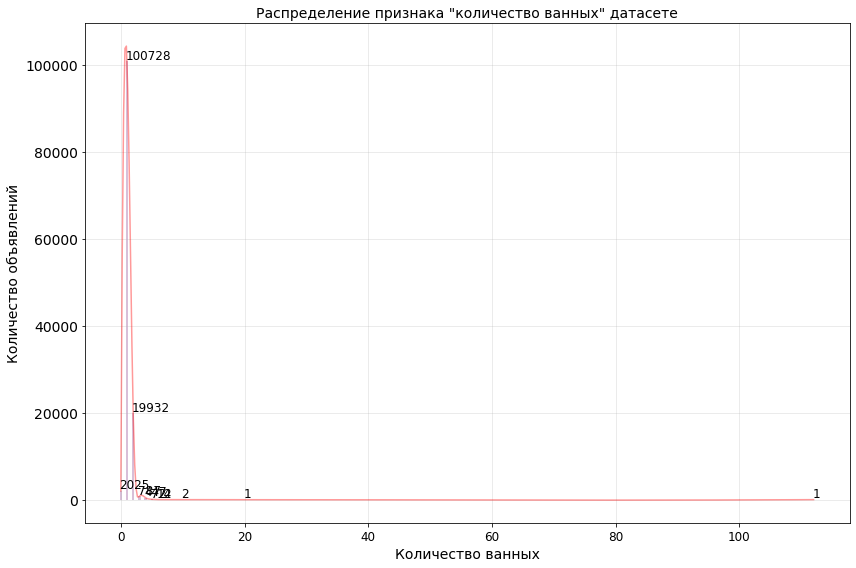

In [17]:
from scipy.interpolate import make_interp_spline

x_0 = concatenated_df['bathrooms'].unique()
y_0 = np.array(concatenated_df['bathrooms'].value_counts())

x = []
y = []
for num in sorted(zip(x_0, y_0)):
    x.append(num[0])
    y.append(num[1])

X_Y_spine = make_interp_spline(x, y)

X = np.linspace(np.min(x), np.max(x), 500)
Y = X_Y_spine(X)

plt.figure(figsize=(12,8))
plt.plot(X, Y, color='r', alpha=0.4)
plt.bar(x, height=y, width=0.4, color='thistle')
for i, v in enumerate(y):
    plt.text(x[i] - 0.20, v + 500, str(v), fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Количество ванных', fontsize=14)
plt.ylabel('Количество объявлений', fontsize=14)
plt.title('Распределение признака "количество ванных" датасете', fontsize=14)
plt.tight_layout()
plt.show()

Из графкка видно, что в датасете имеется некоторое количество выбросов, где данный признак принимает аномальные значения (около 20 или 115). Проанализируем датасет без учета данных выбросов.

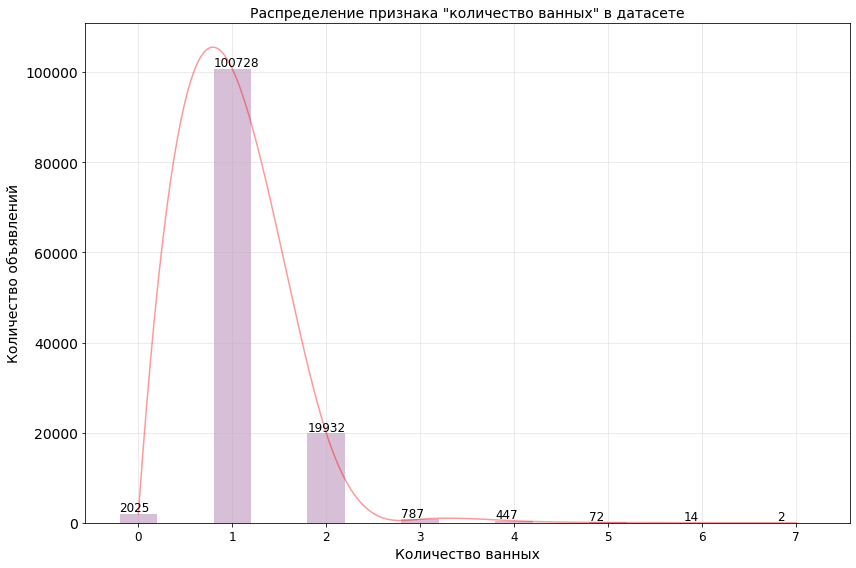

In [18]:
x_0 = concatenated_df['bathrooms'].unique()
y_0 = np.array(concatenated_df['bathrooms'].value_counts())

x = []
y = []
for num in sorted(zip(x_0, y_0)):
    x.append(num[0])
    y.append(num[1])
del x[-3:]
del y[-3:]

X_Y_spine = make_interp_spline(x, y)

X = np.linspace(np.min(x), np.max(x), 500)
Y = X_Y_spine(X)

plt.figure(figsize=(12,8))
plt.plot(X, Y, color='r', alpha=0.4)
plt.bar(x, height=y, width=0.4, color='thistle')
for i, v in enumerate(y):
    plt.text(x[i] - 0.20, v + 500, str(v), fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Количество ванных', fontsize=14)
plt.ylabel('Количество объявлений', fontsize=14)
plt.title('Распределение признака "количество ванных" в датасете', fontsize=14)
plt.tight_layout()
plt.show()

Заметно, что подавляющее большинство объявлений имеют $1$ ванную комнату. На втором месте $2$ ванных комнат, в нескольких тысячах объявлений данный признак имел значение $0$. Значение $3$ и более признак принимал в меньшинстве случаев, в совокупности не превышающим значения признака $0$. Таким образом, можно говорить о том, что в датасете значение признака больше $2$ можно считать своего рода выбросом.

Перейдем к рассмотрению признака `bedrooms`, который иллюстрирует количество спален в объявлении.

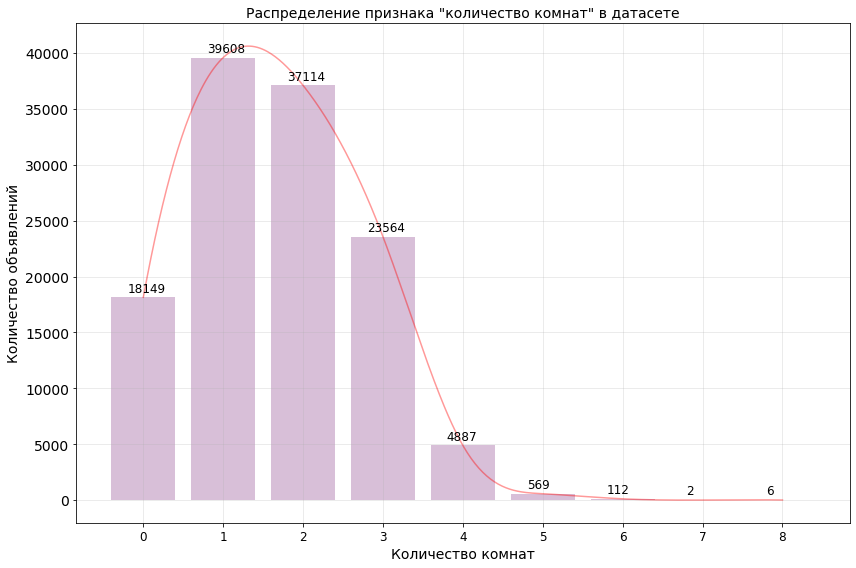

In [19]:
x_0 = concatenated_df['bedrooms'].unique()
y_0 = np.array(concatenated_df['bedrooms'].value_counts())

x = []
y = []
for num in sorted(zip(x_0, y_0)):
    x.append(num[0])
    y.append(num[1])

X_Y_spine = make_interp_spline(x, y)

X = np.linspace(np.min(x), np.max(x), 500)
Y = X_Y_spine(X)

plt.figure(figsize=(12,8))
plt.plot(X, Y, color='r', alpha=0.4)
plt.bar(x, height=y, width=0.8, color='thistle')
for i, v in enumerate(y):
    plt.text(x[i] - 0.20, v + 500, str(v), fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(x, fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Количество комнат', fontsize=14)
plt.ylabel('Количество объявлений', fontsize=14)
plt.title('Распределение признака "количество комнат" в датасете', fontsize=14)
plt.tight_layout()
plt.show()

Количество комнат распределилось более лучшим образом, заметно, что у признака в распределении имеется хвост справа. Помимо этого, признак в основном принимает значение $1$ и $2$. В целом же, значение признака, равное $5$ и более, может указывать на выброс.

Посмотрим на то, каким образом распредилились объявления в зависимости от признака `month`, то есть в зависимости от месяца.

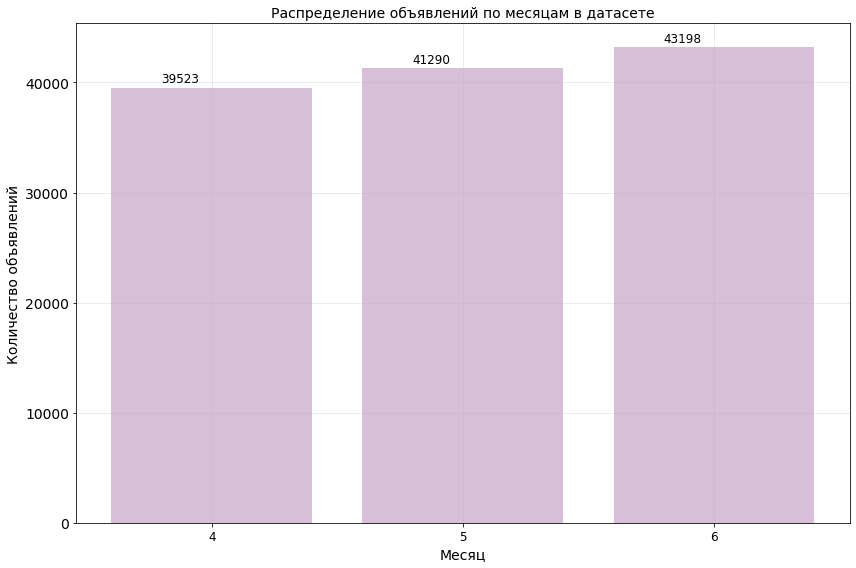

In [20]:
x = concatenated_df['month'].unique()
y = np.array(concatenated_df['month'].value_counts())

plt.figure(figsize=(12,8))
plt.bar(x, height=y, width=0.8, color='thistle')
for i, v in enumerate(y):
    plt.text(x[i] - 0.20, v + 500, str(v), fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(x, fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Месяц', fontsize=14)
plt.ylabel('Количество объявлений', fontsize=14)
plt.title('Распределение объявлений по месяцам в датасете', fontsize=14)
plt.tight_layout()
plt.show()

В итоге, объявления практически равным образом разделились на $3$ подряд идущих месяцев - с апреля по июнь.

Возможно, что в разрезе дней или признака `day` мы обнаружим более интересную картину.

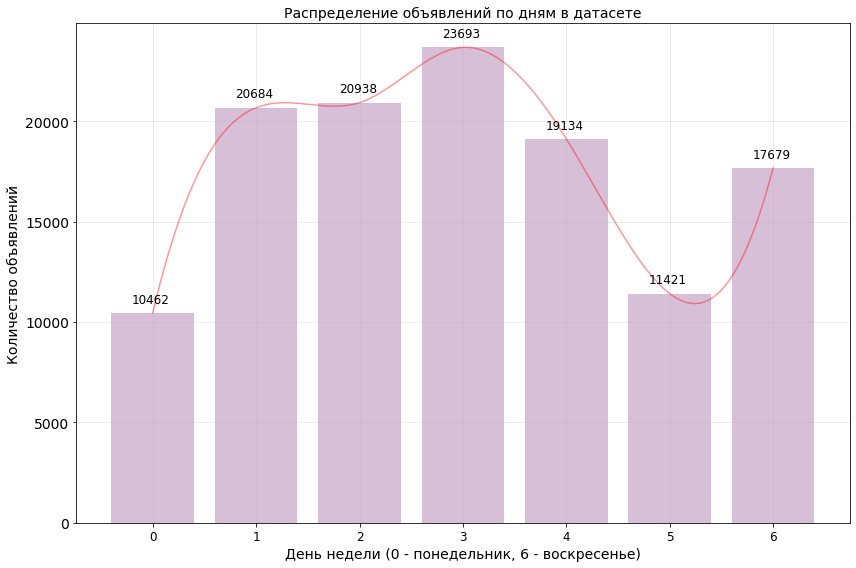

In [21]:
x_0 = concatenated_df['day'].unique()
y_0 = np.array(concatenated_df['day'].value_counts())

x = []
y = []
for num in sorted(zip(x_0, y_0)):
    x.append(num[0])
    y.append(num[1])

X_Y_spine = make_interp_spline(x, y)

X = np.linspace(np.min(x), np.max(x), 500)
Y = X_Y_spine(X)

plt.figure(figsize=(12,8))
plt.plot(X, Y, color='r', alpha=0.4)
plt.bar(x, height=y, width=0.8, color='thistle')
for i, v in enumerate(y):
    plt.text(x[i] - 0.20, v + 500, str(v), fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(x, fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('День недели (0 - понедельник, 6 - воскресенье)', fontsize=14)
plt.ylabel('Количество объявлений', fontsize=14)
plt.title('Распределение объявлений по дням в датасете', fontsize=14)
plt.tight_layout()
plt.show()

По графику можно предположить, что больше всего объявлений было опубликовано в четверг и во вторник (практически равнозначно со средой). Меньше всего объявления публиковались в понедельник и в субботу, то есть чаще люди публиковали объявления либо "на неделе" со вторника по пятницу, либо уже в воскресенье.

Теперь переключимся на время создания объявления, на признак `hour`.

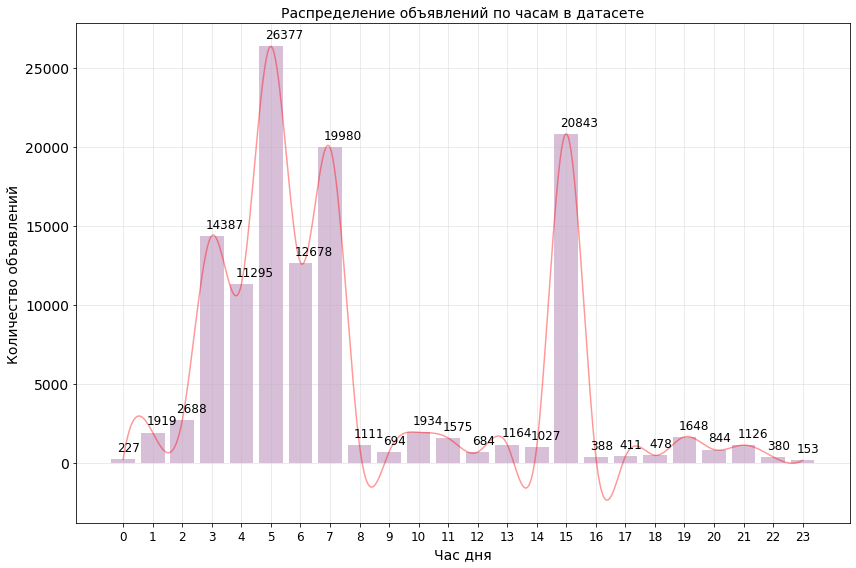

In [22]:
x_0 = concatenated_df['hour'].unique()
y_0 = np.array(concatenated_df['hour'].value_counts())

x = []
y = []
for num in sorted(zip(x_0, y_0)):
    x.append(num[0])
    y.append(num[1])

X_Y_spine = make_interp_spline(x, y)

X = np.linspace(np.min(x), np.max(x), 500)
Y = X_Y_spine(X)

plt.figure(figsize=(12,8))
plt.plot(X, Y, color='r', alpha=0.4)
plt.bar(x, height=y, width=0.8, color='thistle')
for i, v in enumerate(y):
    plt.text(x[i] - 0.20, v + 500, str(v), fontsize=12)
plt.grid(alpha=0.3)
plt.xticks(x, fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Час дня', fontsize=14)
plt.ylabel('Количество объявлений', fontsize=14)
plt.title('Распределение объявлений по часам в датасете', fontsize=14)
plt.tight_layout()
plt.show()

Как ни странно, но больше всего объявлений было опубликовано в ночные и утренние часы: 3-7 часов. Возможно, здесь имеет место быть следующее объяснение: данные были преобработаны из 12-часового формата, используемого в США, в 24-часовой формат, потому время некорректно было преобразовано. В целом же, публикации происходили ночью-утром либо же в 15 часов дня, в остальное время публикаций было заметно меньше.

Наконец, можно посмотреть и на цены объявлений, то есть на признак `price`, может быть здесь будут какие-либо интересные особенности.

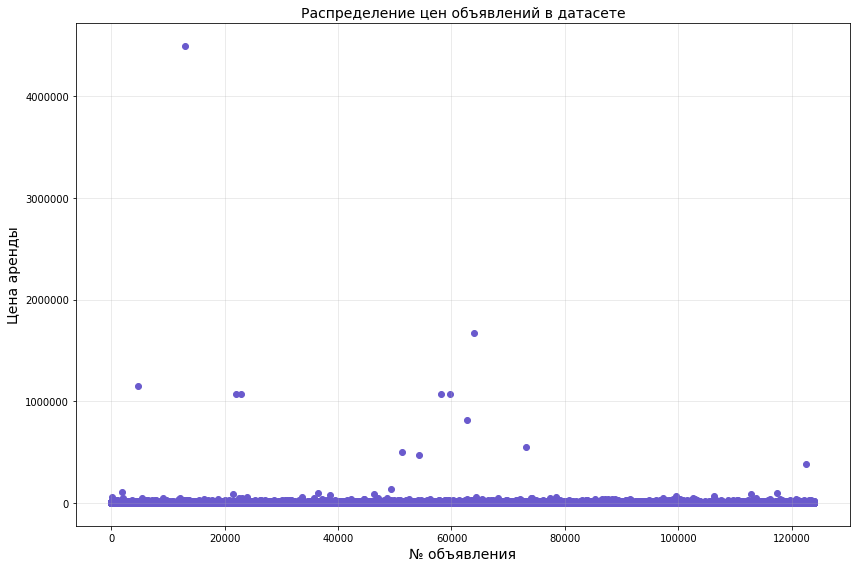

In [23]:
plt.figure(figsize=(12,8))
plt.scatter(x=np.arange(0, concatenated_df.shape[0]), y=concatenated_df['price'], color='slateblue')
plt.grid(alpha=0.3)
plt.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('№ объявления', fontsize=14)
plt.ylabel('Цена аренды', fontsize=14)
plt.title('Распределение цен объявлений в датасете', fontsize=14)
plt.tight_layout()
plt.show()

В данном случае в датасете присутствует некоторое количество заметных выбросов, разительно отличающиеся от цен большинства объявлений. Попробуем рассмотреть данный признак без подобных выбросов.

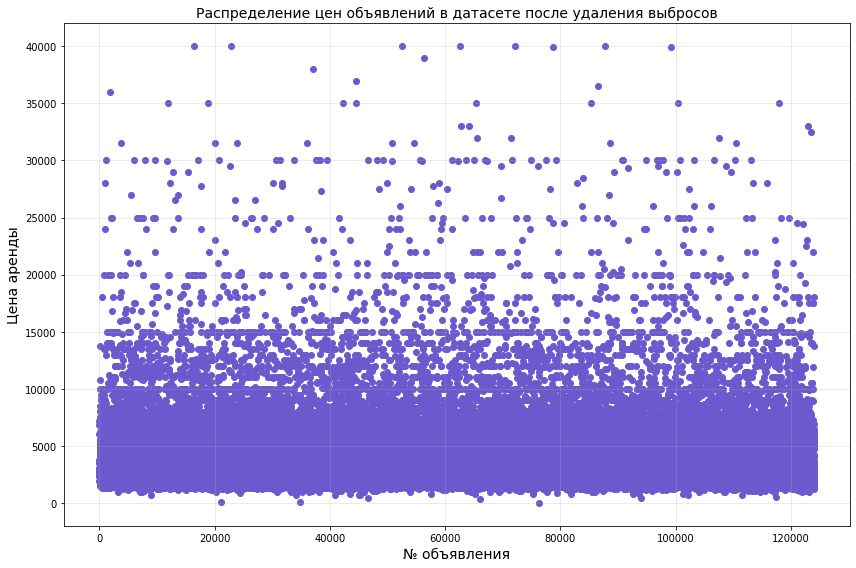

In [24]:
x=np.arange(0, concatenated_df.shape[0])
y=concatenated_df['price']

sorted_by_y = list(zip(x,y))
sorted_by_y.sort(key=lambda x: x[1])

x = []
y = []
for x_y in sorted_by_y:
    x.append(x_y[0])
    y.append(x_y[1])

del y[-50:]
del x[-50:]

plt.figure(figsize=(12,8))
plt.scatter(x, y, color='slateblue')
plt.grid(alpha=0.3)
plt.ticklabel_format(useOffset=False, style='plain')
plt.xlabel('№ объявления', fontsize=14)
plt.ylabel('Цена аренды', fontsize=14)
plt.title('Распределение цен объявлений в датасете после удаления выбросов', fontsize=14)
plt.tight_layout()
plt.show()

Здесь можно отметить то, что наибольшее скопление точек, или же подавляющее большинство объявлений имели цену до $15000$.

В завершение, воспользовавшись признаками `latitude` и `longitude`, посмотрим на карту, чтобы узнать, где находятся наши объявления.

In [25]:
import folium
geometry = [xy for xy in zip(train_df['latitude'], train_df['longitude'])]
avg_long = np.mean(train_df['longitude'])
avg_lat = np.mean(train_df['latitude'])
map_of_listings = folium.Map(location=[avg_lat, avg_long], zoom_start=14)
for point in geometry[0:500]:
    folium.Marker(point).add_to(map_of_listings)
    
map_of_listings

В разрее 500 объявлений получается, что практически все из них сосредоточены в городе Нью-Йорк. Лишь одно объявление было сделано в Бостоне, возможно, что это тоже своего рода выброс в связи с некорректными данными.

Помимо всего прочего, можно дополнительно рассмотреть итоговые корреляции между признаками, чтобы понять, между какими из них наблюдается наибольшая зависимость.

In [26]:
concatenated_df.corr()

,index,bathrooms,bedrooms,latitude,listing_id,longitude,manager_count,photos,price,month,day,hour,rooms,price_per_room
index,1.000000,-0.010641,-0.015316,-0.004850,-0.799046,0.004105,0.024441,-0.008850,-0.008163,-0.879953,0.019616,-0.077583,-0.015849,-0.006477
bathrooms,-0.010641,1.000000,0.441331,0.000153,0.005994,-0.000187,0.003274,0.118019,0.079839,0.009890,-0.017057,-0.004498,0.733532,-0.012239
bedrooms,-0.015316,0.441331,1.000000,-0.003446,0.011994,0.004327,0.009530,0.156546,0.069763,0.016503,-0.018844,0.039524,0.933615,-0.070638
latitude,-0.004850,0.000153,-0.003446,1.000000,0.005435,-0.965539,0.003083,-0.004580,0.000266,0.004918,0.006610,-0.042114,-0.002549,0.000566
listing_id,-0.799046,0.005994,0.011994,0.005435,1.000000,-0.004675,-0.030269,0.012144,0.009718,0.907282,-0.020171,0.111925,0.011477,0.008834
longitude,0.004105,-0.000187,0.004327,-0.965539,-0.004675,1.000000,-0.004713,0.002449,-0.000974,-0.004193,-0.005549,0.035893,0.003203,-0.001734
manager_count,0.024441,0.003274,0.009530,0.003083,-0.030269,-0.004713,1.000000,0.005986,-0.000363,-0.027604,0.019874,-0.002479,0.008526,-0.000866
photos,-0.008850,0.118019,0.156546,-0.004580,0.012144,0.002449,0.005986,1.000000,0.010783,0.010378,-0.015923,0.069015,0.165690,-0.013743
price,-0.008163,0.079839,0.069763,0.000266,0.009718,-0.000974,-0.000363,0.010783,1.000000,0.008513,0.002105,-0.004393,0.084716,0.960482
month,-0.879953,0.009890,0.016503,0.004918,0.907282,-0.004193,-0.027604,0.010378,0.008513,1.000000,-0.022324,0.088011,0.016448,0.006619


Наибольшие корреляции наблюдаются между следующими признаками: 
- между количеством ванных (`bathrooms`) и спален (`bedrooms`) - $0.44$: корреляция между ними средняя, в то же время, можно сказать о том, что имеется некоторая зависимость между двумя признаками


- между количеством комнат (`rooms`) и количеством ванных (`bathrooms`) и спален (`bedrooms`) - $0.73$ и $0.93$ соответственно: корреляция между признаками средняя и сильная (в случае с комнатами и спальнями), что объясняется большим количеством возможных значений количества спален, что и служит большей зависимости; более того, признак количества признак был создан искусственно на имеющихся данных, оттого и высокая корреляция 


- между долготой (`longitude`) и широтой (`latitude`) - $0.96$: и тот, и другой признак объясняет местоположение объекта объявления, тем самым, корреляция между ними высокая (через один признак мы можем с большой уверенностью выяснить и другой признак)


- между ценой объявления (`price`) и ценой за комнату (`price_per_room`) - $0.96$: цена за комнату - искусственный признак, оттого и сильная корреляция между двумя данными признаками; интересно то, что признак цены за комнату практически не коррелирует с признаком количества комнат, что, возможно, обусловлено различной размерностью `price` и `rooms`, где как раз `price` имеет гораздо большие значения


- между _id_ объявления (`listing_id`) и месяцем объявления (`month`) - $0.91$: достаточно интересно то, что _id_ объявления оказалось значительно связано с  месяцем объявления, тем не менее, это объясняется и тем, что в данном датасете присутствует всего 3 месяца, возрастающих с возрастанием _id_ объявления, потому и имеется столь сильная корреляция.


Остальные признаки не имеют сильной корреляции между друг другом, что объясняется как и различной размерностью признаков, так и отсутствием настоящей корреляции между ними.

В данной работе признак `listing_id` использоваться не будет, так как, по сути, это признак, отвечающий за номер объявления.

In [27]:
concatenated_df.drop(columns='listing_id', inplace=True)

До сих пор мы не трогали _текстовые и категориальные признаки_: имеются в виду `description`, `display_address`, `features` и `street_address`. Это достаточно сильные признаки, которые могут принести огромную _пользу_ при последующем обучении модели. Но для того, чтобы они были адекватно восприняты моделью, необходимо провести их предобработку.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
import re

Сначала мы обработаем признак `description`. По своему значению это то поле с описанием объявления, где публикующий может указать информацию о объекте. В себе этот признак может иметь как слова, так и цифры. Цифры в данной работе не будут использоваться вследствие необходимости их значительной обработки (в объявлениях встречаются слова, слитые воедино с цифрами, что дополнительно будет создавать трудности в их отнесении к настоящему слову без цифр).


Для обработки признака мы воспользуемся __мешком слов__. То есть функция создаст столько признаков, сколько в итоге найдет слов в описании. Далее, для каждого объявления алгоритм подсчитает количество использования того или иного слова из общего множества слов-признаков.

In [30]:
vectorizer_desc = CountVectorizer()
vectorized_description = vectorizer_desc.fit_transform(
    concatenated_df['description'].apply(lambda x: re.sub(r'[0-9_]+', '', x)).apply(
        lambda x: re.sub(r'\b\w{1,2}\b', '', x)
    )
)

Такую же операцию мы проведем и с признаком `features`. Он схож по своей натуре с признаком `description`, но содержит в себе ключевую "выжимку", то есть наиболее значительные составляющие объекта.

In [31]:
vectorizer_features = CountVectorizer()
vectorized_features = vectorizer_features.fit_transform(
    concatenated_df['features'].astype('str').apply(lambda x: re.sub(r'[0-9_]+', '', x)).apply(
        lambda x: re.sub(r'\b\w{1,2}\b', '', x)
    )
)

Теперь, когда мы преобразовали признаки `description` и `features`, можно удалить их исходные версии из датасета. Помимо этого, удалим признак `streed_address` - он несет в себе точное расположение объекта, но мы и так можем узнать это исходя из признаков широты и долготы. Помимо этого, признак `display_address` как раз содержит общее указание на улицу, где находится объект, потому будет полезнее воспользоваться  им.

In [32]:
concatenated_df.drop(columns=['description', 'features', 'street_address'], inplace=True)

In [33]:
concatenated_df.head()

,index,bathrooms,bedrooms,display_address,latitude,longitude,manager_count,photos,price,interest_level,month,day,hour,rooms,price_per_room
0,0,1,1,145 Borinquen Place,40.7108,-73.9539,294,12,2400,medium,6,3,5,2,1200.000000
1,1,1,2,East 44th,40.7513,-73.9722,64,6,3800,low,6,2,5,3,1266.666667
2,2,1,2,East 56th Street,40.7575,-73.9625,265,6,3495,medium,6,1,15,3,1165.000000
3,3,1,3,Metropolitan Avenue,40.7145,-73.9425,235,5,3000,medium,6,4,7,4,750.000000
4,4,1,0,East 34th Street,40.7439,-73.9743,135,4,2795,low,6,1,3,1,2795.000000


Займемся обработкой признака `display_address`. Он указывает на улицу, где расположен объект, а потому, может повторяться среди объявлений. Можно считать, что это категориальный признак, а потому его необходимо обработать соответствующим образом: создать столько признаков, сколько имеется уникальных значений `display_address`, а после для каждого объявления ставить $1$ в получившемся адресе-признаке, который был указан в объявлении.

In [34]:
from sklearn.preprocessing import OneHotEncoder

In [35]:
concatenated_df['display_address'] = concatenated_df['display_address'].apply(lambda x: x.lower())

In [36]:
encoder = OneHotEncoder()
encoded_address = encoder.fit_transform(np.reshape(concatenated_df['display_address'].to_numpy(), (-1, 1)))

In [37]:
concatenated_df.drop(columns='display_address', inplace=True)

In [38]:
from scipy.sparse import csr_matrix, hstack

Наконец, все признаки обработаны.

Отделим целевую переменную `interest_level` от датасета, чтобы можно было отдельно работать с признаками и с целевой переменной.

In [39]:
train_test_y = concatenated_df['interest_level']
concatenated_df.drop(columns='interest_level', inplace=True)

Теперь необходимо объединить получившийся датасет с обработанными признаками `description` и `features`. Вследствие большого объема, они хранятся в формате _sparse matrix_, потому датасет будет преобразован в данный формат и будет в дальнейшем использоваться именно в данном формате.

In [40]:
concatenated_df = csr_matrix(concatenated_df.to_numpy())

In [41]:
concatenated_df = hstack([concatenated_df, vectorized_description])
concatenated_df = hstack([concatenated_df, vectorized_features])
concatenated_df = hstack([concatenated_df, encoded_address])
concatenated_df

<124011x61609 sparse matrix of type '<class 'numpy.float64'>'
	with 10223857 stored elements in COOrdinate format>

Разделим обратно объединенный датасет в обучающий и тестовый датасеты. Для этого необходимо вспомнить размерность (а именно количество строк) исходного обучающего датасета, чтобы по нему разделить объединенный датасет. Так как мы никак не меняли расположение строк в датасете, можно использовать данный прием. 

In [42]:
shape_train = train_df.shape[0]
train_df.shape

(49352, 15)

In [43]:
train_df = concatenated_df.tocsr()[0:shape_train, :]
test_df = concatenated_df.tocsr()[shape_train:, :]

In [44]:
train_y = train_test_y[0:shape_train]
test_y = train_test_y[shape_train:]

Дополнительно преобразуем целевую переменную так, чтобы метки были представлены в числовом формате.

In [45]:
from sklearn.preprocessing import LabelEncoder

In [46]:
label_encoder = LabelEncoder()
train_y = label_encoder.fit_transform(train_y)
train_y

array([2, 1, 2, ..., 2, 2, 0])

Целевые метки, которые были закодированы:

In [47]:
label_encoder.classes_

array(['high', 'low', 'medium'], dtype=object)

### Создание и обучение модели градиентного бустинга на основе catboost

Теперь, когда все готово для обучения, можно перейти к созданию и анализу качества обучения модели градиентного бустинга. 


В качестве модели мы будем использовать _CatBoostClassifier_ из библиотеки _catboost_. Эта модель имеет ряд преимуществ, в том числе возможность использования gpu для обучения и предсказания, что нам необходимо для возможности увеличения итераций (деревьев) градиентного бустинга и его более быстрого обучения.

In [48]:
from catboost import CatBoostClassifier, cv, Pool

Начнем подбор параметров для нашей модели. Для начала посмотрим, какой лучше всего выбрать learning_rate.

In [49]:
param_grid = {'learning_rate': [0.01, 0.02, 0.03],
              'l2_leaf_reg': [3.0]}

Так как у нас имеется больше, чем 2 метки (3 метки), перед нами встает __задача мультиклассовой классификации__. _Catboost_ дает возможность работать с подобного рода задачей при указании соответствующего параметра и использования loss (функции потерь), подходящей под данную задачу. В данном случае будет использоваться `MultiClass` loss. Подробнее об использовании данной функции потерь в _catboost_ можно узнать [здесь](https://catboost.ai/en/docs/concepts/loss-functions-multiclassification#objectives-and-metrics).

В процессе обучения будет использоваться встроенная возможность _catboost_ для визуализации. Для корректной работы данной возможности необходимо соблюсти ряд условий, подробнее [здесь](https://catboost.ai/en/docs/installation/python-installation-additional-data-visualization-packages).

In [50]:
model = CatBoostClassifier(iterations=4000,
                           objective='MultiClass',
                           loss_function='MultiClass',
                           eval_metric='MultiClass',
                           verbose=False,
                           task_type='GPU')

results = model.grid_search(param_grid,
                           X=train_df,
                           y=train_y,
                           plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

bestTest = 0.5827815539
bestIteration = 3998
0:	loss: 0.5827816	best: 0.5827816 (0)	total: 2m 12s	remaining: 4m 24s
bestTest = 0.5777775491
bestIteration = 3998
1:	loss: 0.5777775	best: 0.5777775 (1)	total: 4m 9s	remaining: 2m 4s
bestTest = 0.5751465388
bestIteration = 3999
2:	loss: 0.5751465	best: 0.5751465 (2)	total: 6m 1s	remaining: 0us
Estimating final quality...
Training on fold [0/3]
bestTest = 0.5745853691
bestIteration = 3998
Training on fold [1/3]
bestTest = 0.5786327223
bestIteration = 3999
Training on fold [2/3]
bestTest = 0.5760907224
bestIteration = 3983


In [51]:
results['params']

{'learning_rate': 0.03, 'l2_leaf_reg': 3.0}

In [52]:
pd.DataFrame(results['cv_results'])

,iterations,test-MultiClass-mean,test-MultiClass-std,train-MultiClass-mean,train-MultiClass-std
0,0,1.075903,0.000346,1.075778,0.000241
1,1,1.054418,0.000221,1.054144,0.000031
2,2,1.034359,0.000414,1.033988,0.000309
3,3,1.015670,0.000157,1.015206,0.000330
4,4,0.998229,0.000062,0.997680,0.000471
...,...,...,...,...,...
3995,3995,0.576442,0.002045,0.515893,0.000850
3996,3996,0.576442,0.002045,0.515890,0.000850
3997,3997,0.576440,0.002045,0.515886,0.000854
3998,3998,0.576440,0.002045,0.515873,0.000847


Видно, что модель показывает лучшее качество (более меньший показатель функции потерь `MultiClass`) при большем значении learning_rate. Попробуем еще увеличить этот параметр. Также посмотрим на то, меняется ли показатель `MultiClass` в зависимости от степени регуляризации _l2_, использующегося в каждом листе дерева градиентного бустинга. Его увеличение говорит о том, что мы наоборот меньше ограничиваем модель.

In [53]:
param_grid = {'learning_rate': [0.03, 0.05, 0.1],
              'l2_leaf_reg': [3.0, 10.0, 20.0]}

In [54]:
model = CatBoostClassifier(iterations=4000,
                           objective='MultiClass',
                           loss_function='MultiClass',
                           eval_metric='MultiClass',
                           verbose=False,
                           task_type='GPU')

results = model.grid_search(param_grid,
                           X=train_df,
                           y=train_y,
                           plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

bestTest = 0.5752585304
bestIteration = 3999
0:	loss: 0.5752585	best: 0.5752585 (0)	total: 1m 51s	remaining: 14m 53s
bestTest = 0.5723606496
bestIteration = 3985
1:	loss: 0.5723606	best: 0.5723606 (1)	total: 3m 37s	remaining: 12m 41s
bestTest = 0.5687757323
bestIteration = 3985
2:	loss: 0.5687757	best: 0.5687757 (2)	total: 5m 20s	remaining: 10m 40s
bestTest = 0.5786334635
bestIteration = 3999
3:	loss: 0.5786335	best: 0.5687757 (2)	total: 7m 12s	remaining: 9m
bestTest = 0.5745056047
bestIteration = 3975
4:	loss: 0.5745056	best: 0.5687757 (2)	total: 8m 59s	remaining: 7m 11s
bestTest = 0.5724582465
bestIteration = 3975
5:	loss: 0.5724582	best: 0.5687757 (2)	total: 10m 42s	remaining: 5m 21s
bestTest = 0.5800667478
bestIteration = 3999
6:	loss: 0.5800667	best: 0.5687757 (2)	total: 12m 35s	remaining: 3m 35s
bestTest = 0.5774433058
bestIteration = 3977
7:	loss: 0.5774433	best: 0.5687757 (2)	total: 14m 24s	remaining: 1m 48s
bestTest = 0.5732182953
bestIteration = 3956
8:	loss: 0.5732183	best: 

По графику заметно, что увеличение параметра регуляризации (то есть уменьшение регуляризации как таковой) оказывает скорее негативное влияние на качество обучения модели. И наоборот, увеличение показателя learning_rate положительно сказалось на обучении. Будем использовать его в значении $0.1$.

Теперь, когда мы осуществили подбор параметров, разобъем обучающий сет дополнительно на сам обучающий сет и на валидационный. Это необходимо для последующей более объективной оценки качества модели.

In [55]:
from sklearn.model_selection import train_test_split

In [56]:
X_train, X_eval, y_train, y_eval = train_test_split(train_df, train_y, shuffle=True, test_size=0.2, random_state=241)

In [57]:
print(f'Количество объектов в обучающей выборке: {X_train.shape[0]}')
print(f'Количество объектов в валидационной выборке: {X_eval.shape[0]}')

Количество объектов в обучающей выборке: 39481
Количество объектов в валидационной выборке: 9871


Посмотрм на то, какой результат выдаст модель при $7000$ итерациях с использованием подобранных параметров (learning_rate - $0.1$, l2_leaf_reg - $3.0$).

In [58]:
eval_data = Pool(X_eval, y_eval)

In [59]:
model = CatBoostClassifier(iterations=7000,
                           depth=6,
                           learning_rate=0.1,
                           l2_leaf_reg=3.0,
                           objective='MultiClass', 
                           loss_function='MultiClass',
                           eval_metric='MultiClass',
                           verbose=False,
                           random_seed=241,
                           task_type='GPU')

model.fit(X_train, y_train, eval_set=eval_data, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

По графику видно, что мы уткунулись в некий предел обучения. Функция потерь для валидационного сета все меньше и меньше (на последних итерациях практически не снижаясь) показывает меньшее значение. В то же время функция потерь на обучающем датасете продолжает снижаться, что говорит о переобучении и необходимости преобразовать признаки еще каким-либо образом.

Посмотрим на несколько метрик качества получившейся модели.

In [60]:
scores = model.eval_metrics(eval_data, metrics=['TotalF1', 'AUC', 'MultiClass'])

In [61]:
precision_recall = model.eval_metrics(eval_data, metrics=['Precision', 'Recall'])

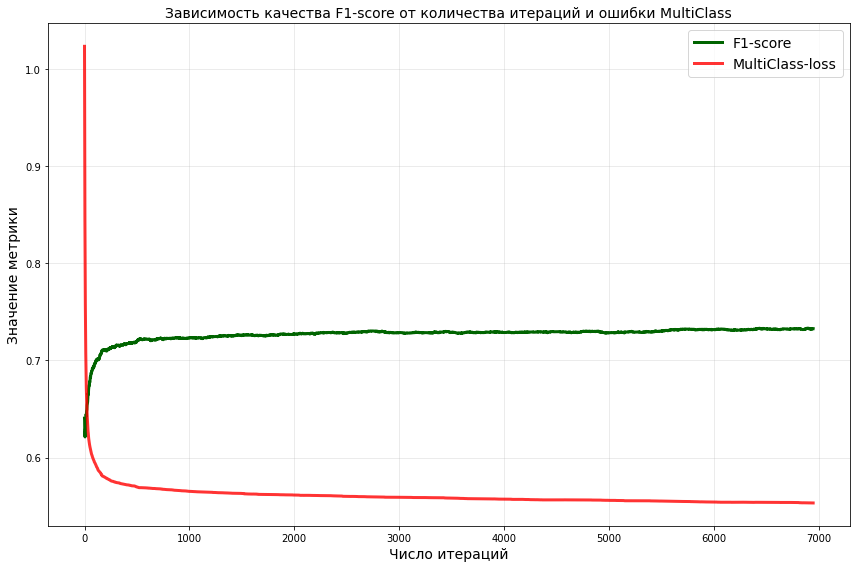

In [62]:
x = np.arange(0, len(scores['TotalF1']), 1)
plt.figure(figsize=(12,8))
plt.plot(x, scores['TotalF1'], label='F1-score', color='darkgreen', lw=3.0)
plt.plot(x, scores['MultiClass'], label='MultiClass-loss', lw=3.0, color='r', alpha=0.8)
plt.grid(alpha=0.3)
plt.xlabel('Число итераций', fontsize=14)
plt.ylabel('Значение метрики', fontsize=14)
plt.title('Зависимость качества F1-score от количества итераций и ошибки MultiClass', fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

Как мы видим, значение `F1-score`, дополнительно преобразованного для учета задачи мультиклассовой классификации, постепенно увеличивается, в то же время, незначительно и не всегда равномерно.

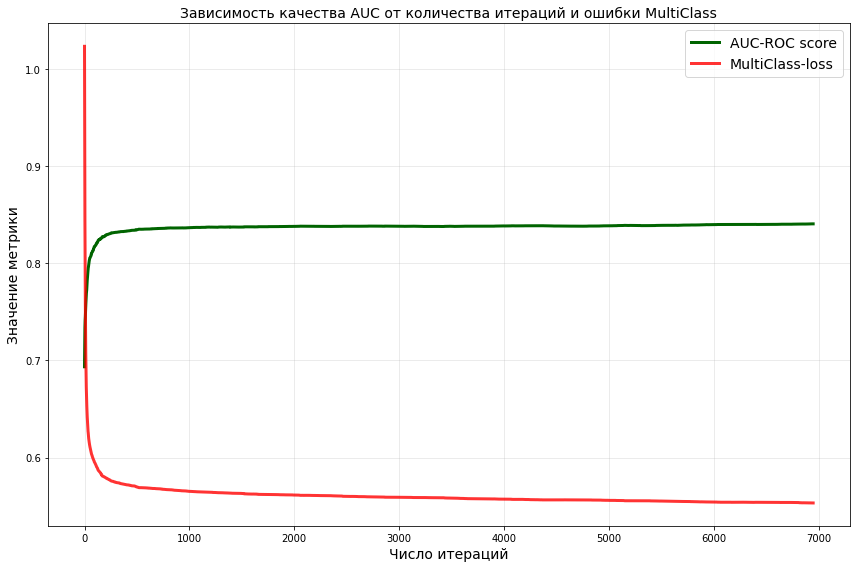

In [63]:
plt.figure(figsize=(12,8))
plt.plot(x, scores['AUC:type=Mu'], label='AUC-ROC score', color='darkgreen', lw=3.0)
plt.plot(x, scores['MultiClass'], label='MultiClass-loss', lw=3.0, color='r', alpha=0.8)
plt.grid(alpha=0.3)
plt.xlabel('Число итераций', fontsize=14)
plt.ylabel('Значение метрики', fontsize=14)
plt.title('Зависимость качества AUC от количества итераций и ошибки MultiClass', fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

Качество `Площадь под ROC-кривой` показывает несколько более плавное увеличение в зависимости от количества итераций. Помимо этого, само по себе качество больше $0.8$ говорит о том, что полученная модель уже имеет хорошее качество.

Наконец, посмотрим на полноту и точности для каждого из трех классов по отдельности.

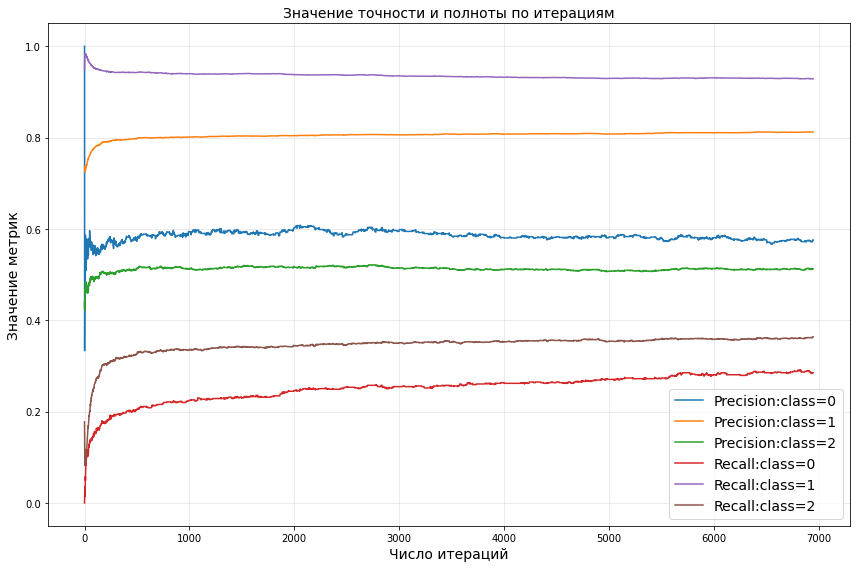

In [64]:
plt.figure(figsize=(12,8))
for metric in precision_recall.keys():
    plt.plot(x, precision_recall[metric], label=metric)
    plt.legend(fontsize=14)
plt.xlabel('Число итераций', fontsize=14)
plt.ylabel('Значение метрик', fontsize=14)
plt.title('Значение точности и полноты по итерациям', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Отчетливо заметно, что получившаяся модель отлично ведет себя с первым классом. Точность и полнота для него имеют значение больше $0.8$. В то же время, Полнота и точность для нулевого и второго класса значительно ниже.


Другими словами, наша модель хорошо научилась отличать класс 1 от всех других, но так и не поняла особенностей класса 2 и класса 0.

Посмотрим на то, какой получилось итоговое качество _log-loss_, _F1-score_ и _ROC-AUC_ для модели.

In [65]:
from sklearn.metrics import log_loss

In [66]:
print(f'Итоговая ошибка log-loss на валидационной выборке: {round(log_loss(y_eval, model.predict_proba(X_eval)), 4)}')

Итоговая ошибка log-loss на валидационной выборке: 0.5532


In [67]:
print(f'Итоговое качество F1-score классификатора с использованием CatBoost: ', end='')
print(f'{round(scores["TotalF1"][-1], 3)}', end='\n')
print(f'Итоговое качество ROC-AUC классификатора с использованием CatBoost: ', end='')
print(f'{round(scores["AUC:type=Mu"][-1], 3)}')

Итоговое качество F1-score классификатора с использованием CatBoost: 0.733
Итоговое качество ROC-AUC классификатора с использованием CatBoost: 0.841


Мы получили достаточно хорошие значения качества указанных метрик. В то же время, возможно, что есть еще шанс увеличить итоговое качество и обучить лучшую модель. Как уже было ранее замечено, модель не может хорошо отличить классы 0 и 2. Быть может, если бы мы увеличили количество объектов с данными целевыми метками, модели удалось бы выявить необходимые закономерности.

### Обучение модели с учетом дисбаланса классов

###### Импорт датасета и аугментация данных 

In [68]:
train_df = pd.read_json('train.json').reset_index().drop(columns='index')
test_df = pd.read_json('test.json').reset_index().drop(columns='index')

In [69]:
train_df['interest_level'].value_counts()

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64

Действительно, в обучающей выборке имеется дисбаланс классов. Так, больше всего представлено как раз объектов класса `low` (именно данный класс лучше всего выявляла модель). Далее количество объектов классов падает, причем класса `high` в обучающей выборке в $10$ раз меньше, чем класса `low`.

Преобразуем наш обучающий датасет так, чтобы в нем имелось равное количество всех классов.

In [70]:
train_df_medium = train_df[train_df.interest_level == 'medium'].copy().reset_index().drop(columns='index')
train_df = pd.concat([train_df, train_df_medium])
train_df = pd.concat([train_df, train_df_medium])
train_df['interest_level'].value_counts()

low       34284
medium    33687
high       3839
Name: interest_level, dtype: int64

In [71]:
train_df_high = train_df[train_df.interest_level == 'high'].copy().reset_index().drop(columns='index')
for i in range(int(train_df['interest_level'].value_counts()[0] / train_df['interest_level'].value_counts()[2])):
    train_df = pd.concat([train_df, train_df_high])
train_df['interest_level'].value_counts()

high      34551
low       34284
medium    33687
Name: interest_level, dtype: int64

Теперь, когда нам удалось сбалансировать классы между друг другом, заново проведем процесс преобразования и инженерии признаков.

###### Преобразование признаков и feature engineering 

In [72]:
concatenated_df = pd.concat([train_df, test_df])

In [73]:
concatenated_df['bathrooms'] = concatenated_df['bathrooms'].astype('int')

In [74]:
concatenated_df.drop(columns='building_id', inplace=True)

In [75]:
concatenated_df['created'] = pd.to_datetime(concatenated_df['created'])
concatenated_df['year'] = concatenated_df['created'].dt.year
concatenated_df['quarter'] = concatenated_df['created'].dt.quarter
concatenated_df['month'] = concatenated_df['created'].dt.month
concatenated_df['day'] = concatenated_df['created'].dt.dayofweek
concatenated_df['hour'] = concatenated_df['created'].dt.hour

In [76]:
concatenated_df.drop(columns=['created', 'year', 'quarter'], inplace=True)

In [77]:
masking = pd.DataFrame(concatenated_df['manager_id'].value_counts()).reset_index().rename(columns={
    'index': 'manager_id', 
    'manager_id': 'count'
})

for manager in masking.values:
    concatenated_df.loc[concatenated_df.manager_id == manager[0], 'manager_id'] = manager[1]
    
concatenated_df.rename(columns={
    'manager_id': 'manager_count'
}, inplace=True)

concatenated_df['manager_count'] = concatenated_df['manager_count'].astype('int')

In [78]:
concatenated_df['photos'] = concatenated_df['photos'].apply(lambda x: len(x))

In [79]:
concatenated_df['rooms'] = concatenated_df['bathrooms'] + concatenated_df['bedrooms']

In [80]:
concatenated_df['price_per_room'] = concatenated_df['price'] / concatenated_df['rooms']

In [81]:
concatenated_df.drop(columns='listing_id', inplace=True)

In [82]:
vectorizer_desc = CountVectorizer()
vectorized_description = vectorizer_desc.fit_transform(
    concatenated_df['description'].apply(lambda x: re.sub(r'[0-9_]+', '', x)).apply(
        lambda x: re.sub(r'\b\w{1,2}\b', '', x)
    )
)

In [83]:
vectorizer_features = CountVectorizer()
vectorized_features = vectorizer_features.fit_transform(
    concatenated_df['features'].astype('str').apply(lambda x: re.sub(r'[0-9_]+', '', x)).apply(
        lambda x: re.sub(r'\b\w{1,2}\b', '', x)
    )
)

In [84]:
concatenated_df.drop(columns=['description', 'features', 'street_address'], inplace=True)

In [85]:
concatenated_df.head()

,bathrooms,bedrooms,display_address,latitude,longitude,manager_count,photos,price,interest_level,month,day,hour,rooms,price_per_room
0,1,1,145 Borinquen Place,40.7108,-73.9539,436,12,2400,medium,6,3,5,2,1200.000000
1,1,2,East 44th,40.7513,-73.9722,104,6,3800,low,6,2,5,3,1266.666667
2,1,2,East 56th Street,40.7575,-73.9625,327,6,3495,medium,6,1,15,3,1165.000000
3,1,3,Metropolitan Avenue,40.7145,-73.9425,281,5,3000,medium,6,4,7,4,750.000000
4,1,0,East 34th Street,40.7439,-73.9743,151,4,2795,low,6,1,3,1,2795.000000


In [86]:
concatenated_df['display_address'] = concatenated_df['display_address'].apply(lambda x: x.lower())

In [87]:
encoder = OneHotEncoder()
encoded_address = encoder.fit_transform(np.reshape(concatenated_df['display_address'].to_numpy(), (-1, 1)))

In [88]:
concatenated_df.drop(columns='display_address', inplace=True)

In [89]:
train_test_y = concatenated_df['interest_level']
concatenated_df.drop(columns='interest_level', inplace=True)

In [90]:
concatenated_df = csr_matrix(concatenated_df.to_numpy())

In [91]:
concatenated_df = hstack([concatenated_df, vectorized_description])
concatenated_df = hstack([concatenated_df, vectorized_features])
concatenated_df = hstack([concatenated_df, encoded_address])
concatenated_df

<177181x61608 sparse matrix of type '<class 'numpy.float64'>'
	with 14586208 stored elements in COOrdinate format>

In [92]:
shape_train = train_df.shape[0]
train_df.shape

(102522, 15)

In [93]:
train_df = concatenated_df.tocsr()[0:shape_train, :]
test_df = concatenated_df.tocsr()[shape_train:, :]

In [94]:
train_y = train_test_y[0:shape_train]

In [95]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_y)
y_train

array([2, 1, 2, ..., 0, 0, 0])

In [96]:
label_encoder.classes_

array(['high', 'low', 'medium'], dtype=object)

###### Обучение модели 

Теперь, когда мы вновь прошли через все этапы преобразования имеющихся признаков и создания новых, можно вновь обучить модель с учетом прежних найденных наилучших параметров. В этот раз, однако, будет использовано большее количество итераций.

Вновь разделим обучающий датасет на обучающий и валидационный.

In [97]:
X_train, X_eval, y_train, y_eval = train_test_split(train_df, train_y, shuffle=True, test_size=0.2, random_state=241)

In [98]:
eval_data = Pool(X_eval, y_eval)

In [99]:
model = CatBoostClassifier(iterations=11000,
                           depth=6,
                           learning_rate=0.1,
                           l2_leaf_reg=3.0,
                           objective='MultiClass', 
                           loss_function='MultiClass',
                           eval_metric='MultiClass',
                           verbose=False,
                           random_seed=241,
                           task_type='GPU')

model.fit(X_train, y_train, eval_set=eval_data, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Как мы видим по получившемуся графику, модель гораздо лучше показала себя после балансировки классов. Мало того, что сам по себе показатель функции потерь оказался меньше, модель не достигла переобучения (функция потерь продолжала уменьшаться до конца как у валидационного, так и обучающего датасетов).

Посмотрим, как изменились итоговые метрики качества. Возьмем все те же `F1-score`, `Площадь под ROC-кривой`.

In [100]:
scores = model.eval_metrics(eval_data, metrics=['TotalF1', 'AUC', 'MultiClass'])

In [101]:
precision_recall = model.eval_metrics(eval_data, metrics=['Precision', 'Recall'])

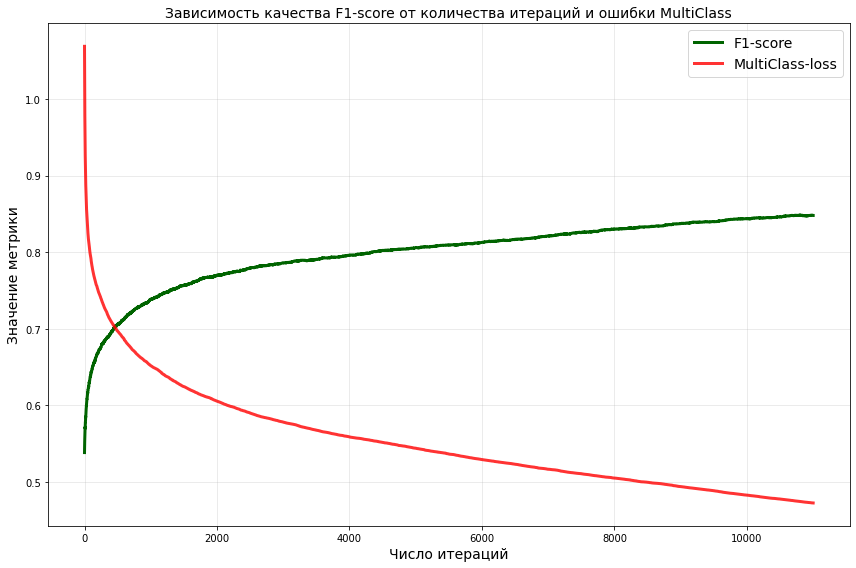

In [102]:
x = np.arange(0, len(scores['TotalF1']), 1)
plt.figure(figsize=(12,8))
plt.plot(x, scores['TotalF1'], label='F1-score', color='darkgreen', lw=3.0)
plt.plot(x, scores['MultiClass'], label='MultiClass-loss', lw=3.0, color='r', alpha=0.8)
plt.grid(alpha=0.3)
plt.xlabel('Число итераций', fontsize=14)
plt.ylabel('Значение метрики', fontsize=14)
plt.title('Зависимость качества F1-score от количества итераций и ошибки MultiClass', fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

_F1-score_ на этот раз гораздо лучшее увеличивает значение в зависимости от количества итераций. Более того, видно, что мы могли бы увеличить количество итераций еще больше для более лучшего результата.

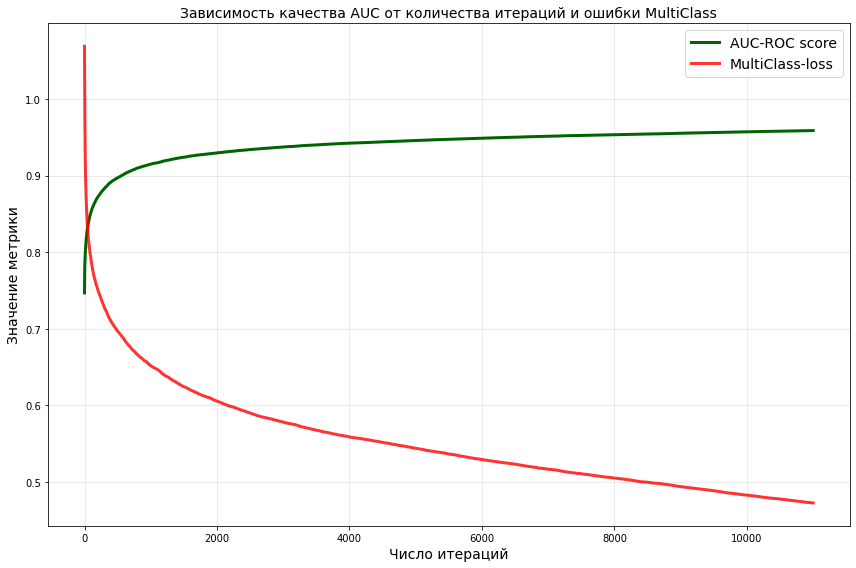

In [103]:
plt.figure(figsize=(12,8))
plt.plot(x, scores['AUC:type=Mu'], label='AUC-ROC score', color='darkgreen', lw=3.0)
plt.plot(x, scores['MultiClass'], label='MultiClass-loss', lw=3.0, color='r', alpha=0.8)
plt.grid(alpha=0.3)
plt.xlabel('Число итераций', fontsize=14)
plt.ylabel('Значение метрики', fontsize=14)
plt.title('Зависимость качества AUC от количества итераций и ошибки MultiClass', fontsize=14)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()

Качество _площади под ROC-кривой_ также увеличилось. Более того, оно максимально приближается к 1.0, что отличный знак.

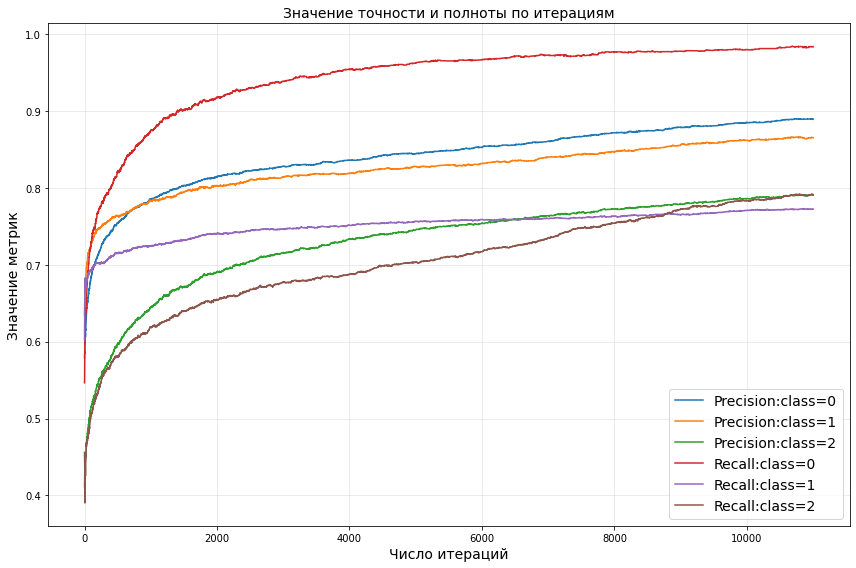

In [104]:
plt.figure(figsize=(12,8))
for metric in precision_recall.keys():
    plt.plot(x, precision_recall[metric], label=metric)
    plt.legend(fontsize=14)
plt.xlabel('Число итераций', fontsize=14)
plt.ylabel('Значение метрик', fontsize=14)
plt.title('Значение точности и полноты по итерациям', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Балансировка классов в датасете отлично сказалась на полноте и точности для всех классов. Конечно, меньше всего увеличились значения у полноты класса 1. В то же время, теперь все значения колеблятся в районе $0.78$ - $0.98$. Другими словами, теперь модель не только отлично отличает класс 1 от всех остальных, но и научилась отделять классы 0 и 2 от других.

In [105]:
print(f'Итоговая ошибка log-loss на валидационной выборке: {round(log_loss(y_eval, model.predict_proba(X_eval)), 4)}')

Итоговая ошибка log-loss на валидационной выборке: 0.4725


In [106]:
print(f'Итоговое качество F1-score классификатора с использованием CatBoost: ', end='')
print(f'{round(scores["TotalF1"][-1], 3)}', end='\n')
print(f'Итоговое качество ROC-AUC классификатора с использованием CatBoost: ', end='')
print(f'{round(scores["AUC:type=Mu"][-1], 3)}')

Итоговое качество F1-score классификатора с использованием CatBoost: 0.848
Итоговое качество ROC-AUC классификатора с использованием CatBoost: 0.959


###### Запись предсказаний модели для тестового датасета в файл для сдачи на kaggle

In [107]:
y_pred_test = model.predict_proba(test_df)
y_pred_test = pd.DataFrame(y_pred_test)

In [108]:
label_encoder.classes_

array(['high', 'low', 'medium'], dtype=object)

In [109]:
y_pred_test.rename({0: 'high', 1: 'low', 2: 'medium'}, axis=1, inplace=True)
y_pred_test = y_pred_test[['high', 'medium', 'low']]
y_pred_test

,high,medium,low
0,0.109144,0.708980,0.181877
1,0.572795,0.295531,0.131674
2,0.010182,0.076196,0.913622
3,0.683621,0.265499,0.050880
4,0.020660,0.245934,0.733406
...,...,...,...
74654,0.839210,0.142386,0.018404
74655,0.075552,0.446239,0.478208
74656,0.000626,0.022667,0.976708
74657,0.001837,0.038100,0.960063


In [110]:
test_df = pd.read_json('test.json').reset_index().drop(columns='index')
submission = pd.concat([pd.DataFrame(test_df['listing_id']), y_pred_test], axis=1)
submission

,listing_id,high,medium,low
0,7142618,0.109144,0.708980,0.181877
1,7210040,0.572795,0.295531,0.131674
2,7174566,0.010182,0.076196,0.913622
3,7191391,0.683621,0.265499,0.050880
4,7171695,0.020660,0.245934,0.733406
...,...,...,...,...
74654,6928108,0.839210,0.142386,0.018404
74655,6906674,0.075552,0.446239,0.478208
74656,6897967,0.000626,0.022667,0.976708
74657,6842183,0.001837,0.038100,0.960063


In [111]:
import os
current_dir = os.getcwd()
submission.to_csv(os.path.join(current_dir, 'sumbission.csv'), index=False)